In [1]:
import pandas as pd
# Prevent pandas from rounding float values
pd.set_option("display.float_format", "{:.4f}".format)


In [1]:
import pandas as pd

# Load the dataset
df= pd.read_csv("capital_1.csv")

# Extract year and quarter from REF_DATE
df['Year'] = df['REF_DATE'].str[:4].astype(int)
df['Quarter'] = df['REF_DATE'].str[5:]

# Filter for Q4 and only "Total non-residential" assets
df_q4 = df[
    (df['Quarter'] == '10') &
    (df['Assets'] == 'Total non-residential')
]

# Keep necessary columns
df_q4 = df_q4[['Year', 'GEO', 'VALUE']]

# Group by Year and GEO (province), summing in case there are duplicates
df_q4_grouped = df_q4.groupby(['Year', 'GEO'], as_index=False)['VALUE'].sum()


# Save to CSV
df_q4_grouped.to_csv("AnnualCapital.csv", index=False)

In [2]:
wage  = pd.read_csv ("wage.csv")

# Filter: Keep only 'Wages and salaries' and Q4 (October of each year)
wage_cleaned = wage[
    (wage['Estimates'] == 'Wages and salaries') &
    (wage['REF_DATE'].str.endswith('-10')) & 
    (wage['REF_DATE'].str[:4].astype(int).between(2015, 2023))
]

# Reset index if needed
wage_cleaned = wage_cleaned.reset_index(drop=True)
wage_cleaned['REF_DATE'] = wage_cleaned['REF_DATE'].str[0:4]
wage_cleaned.to_csv("wage_cleaned.csv", index=False)

index = pd.read_csv("index.csv")

# Filter index_df for "Final domestic demand" from 2015 to 2023
index_filtered = index[
    (index['Estimates'] == 'Final domestic demand') &
    (index['REF_DATE'].astype(str).between('2015', '2023'))
][['REF_DATE', 'VALUE']]

# Rename index column to be more descriptive
index_filtered = index_filtered.rename(columns={'VALUE': 'Price_Index'})
wage_cleaned['REF_DATE'] = wage_cleaned['REF_DATE'].astype(str)
index_filtered['REF_DATE'] = index_filtered['REF_DATE'].astype(str)

# Now merge
merged_df = pd.merge(wage_cleaned, index_filtered, on='REF_DATE', how='left')

merged_df = pd.merge(wage_cleaned, index_filtered, on='REF_DATE', how='left')

columns_to_keep = ['REF_DATE','Price_Index','VALUE']

merged_df.columns
wage_df = merged_df[columns_to_keep]
wage_df['real_wage'] = wage_df['VALUE'] / wage_df['Price_Index'] *100
wage_df.head(10)

C:\Users\logc0\AppData\Local\Temp\ipykernel_115216\681364818.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df['real_wage'] = wage_df['VALUE'] / wage_df['Price_Index'] *100


,REF_DATE,Price_Index,VALUE,real_wage
0,2015,97.6,886292,9.080861e+05
1,2016,98.6,886616,8.992049e+05
2,2017,100.0,945328,9.453280e+05
3,2018,101.6,986268,9.707362e+05
4,2019,103.5,1034668,9.996792e+05
5,2020,105.4,1038524,9.853169e+05
6,2021,109.4,1139588,1.041671e+06
7,2022,116.3,1227824,1.055739e+06
8,2023,120.6,1303740,1.081045e+06


In [3]:
import pandas as pd
import os

# List of years to process
years = range(2015, 2024)

# List to hold each year's filtered DataFrame
filtered_dataframes = []

for year in years:
    file_name = f"{year}.csv"
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
        # Filter for 'Population' and 'Employment'
        df_filtered = df[df['Labour force characteristics'].isin(['Population', 'Employment'])]
        # Keep only relevant columns
        df_filtered = df_filtered[['REF_DATE', 'GEO', 'Labour force characteristics', 'VALUE']]
        filtered_dataframes.append(df_filtered)
    else:
        print(f"File {file_name} not found, skipping.")

# Combine all years
merged_df = pd.concat(filtered_dataframes, ignore_index=True)

# Pivot the table
final_df = merged_df.pivot_table(
    index=['REF_DATE', 'GEO'],
    columns='Labour force characteristics',
    values='VALUE'
).reset_index()

# Save to CSV
final_df.to_csv('labor_data.csv', index=False)

In [71]:

# Load the dataset
file_path = "GDP.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Filter dataset to keep only 'Final domestic demand'
df_filtered = df[df['Estimates'] == 'Final domestic demand']

# Save to a new CSV file
df_filtered.to_csv("GDPData.csv", index=False)

print("GDP dataset saved successfully!")

GDP dataset saved successfully!


In [8]:
import pandas as pd

# Load datasets
capital_df = pd.read_csv("AnnualCapital.csv")  # Capital stock (K)
gdp_df = pd.read_csv("GDPData.csv")            # GDP (Y)
labor_df = pd.read_csv("labor_data.csv")       # Employment & Population

# === Clean labor_data.csv ===
# Extract Year from 'REF_DATE'
labor_df["Year"] = pd.to_datetime(labor_df["REF_DATE"]).dt.year

# Use Employment as L and convert to millions
labor_df = labor_df[["Year", "GEO", "Employment"]].rename(columns={"Employment": "L"})
labor_df["L"] = labor_df["L"] / 1000

# === Clean GDP data ===
# Keep only "Final domestic demand"
gdp_df = gdp_df[gdp_df["Estimates"] == "Final domestic demand"]
gdp_df = gdp_df.rename(columns={"REF_DATE": "Year", "VALUE": "Y"})
gdp_df["Year"] = gdp_df["Year"].astype(int)
gdp_df = gdp_df[["Year", "GEO", "Y"]]

# === Clean Capital data ===
capital_df = capital_df.rename(columns={"VALUE": "K"})
capital_df["Year"] = capital_df["Year"].astype(int)
capital_df = capital_df[["Year", "GEO", "K"]]

# === Merge all three datasets on Year and GEO ===
merged_df = gdp_df.merge(capital_df, on=["Year", "GEO"], how="inner") \
                  .merge(labor_df, on=["Year", "GEO"], how="inner")

# Save merged dataset
merged_df.to_csv("Merged_K_Y_L.csv", index=False)

print("✅ Merged dataset saved as 'Merged_K_Y_L.csv'")
print(merged_df.head())

✅ Merged dataset saved as 'Merged_K_Y_L.csv'
   Year     GEO        Y        K        L
0  2015  Canada  2091469  2446114  17.8674
1  2016  Canada  2101103  2454819  18.1040
2  2017  Canada  2170094  2475883  18.6197
3  2018  Canada  2228262  2505162  18.8928
4  2019  Canada  2257230  2534378  19.1865


In [12]:
import pandas as pd

# Load both datasets
merged_df = pd.read_csv("Merged_K_Y_L.csv")
wage_df = pd.read_csv("wage_cleaned.csv")

# Prepare the wage data: rename columns and format Year
wage_df = wage_df.rename(columns={"REF_DATE": "Year", "VALUE": "WAGE"})
wage_df["Year"] = wage_df["Year"].astype(int)
wage_df = wage_df[["Year", "GEO", "WAGE"]]

# Merge into main dataset
merged_with_wage = merged_df.merge(wage_df, on=["Year", "GEO"], how="left")

# Save to new CSV
merged_with_wage.to_csv("Merged_K_Y_L_WAGE.csv", index=False)

print("✅ Merged with wage data and saved as 'Merged_K_Y_L_WAGE.csv'")
print(merged_with_wage.head(10))

✅ Merged with wage data and saved as 'Merged_K_Y_L_WAGE.csv'
   Year                        GEO        Y        K        L       WAGE
0  2015                     Canada  2091469  2446114  17.8674   886292.0
1  2016                     Canada  2101103  2454819  18.1040   886616.0
2  2017                     Canada  2170094  2475883  18.6197   945328.0
3  2018                     Canada  2228262  2505162  18.8928   986268.0
4  2019                     Canada  2257230  2534378  19.1865  1034668.0
5  2020                     Canada  2164051  2534987  18.5917  1038524.0
6  2021                     Canada  2302441  2549886  19.5088  1139588.0
7  2022                     Canada  2379170  2575311  19.9985  1227824.0
8  2023                     Canada  2405571  2605937  20.5328  1303740.0
9  2015  Newfoundland and Labrador    37475    60897   0.2374        NaN


   Year     alpha
0  2015  0.364352
1  2016  0.367035
2  2017  0.346576
3  2018  0.336074
4  2019  0.312431
5  2020  0.280153
6  2021  0.257578
7  2022  0.225891
8  2023  0.187050


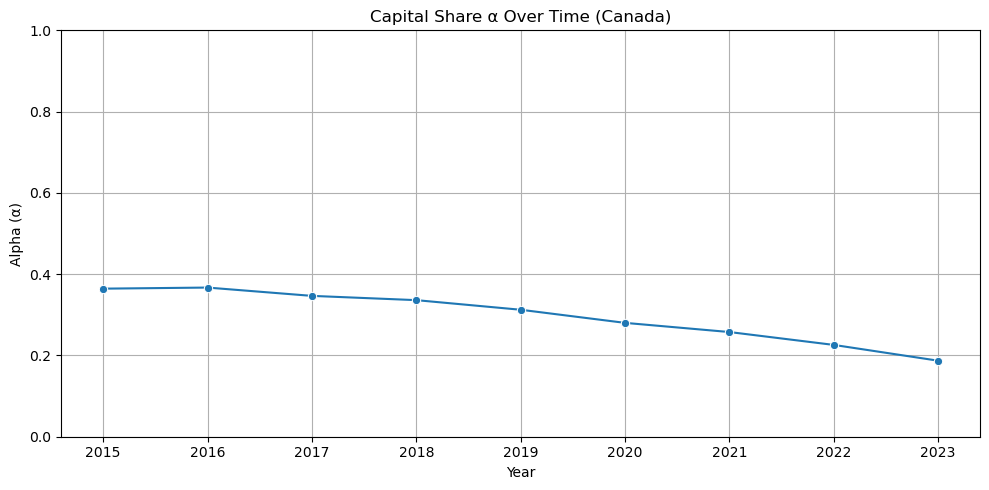

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the merged dataset
df = pd.read_csv("Merged_K_Y_L_WAGE.csv")

# Step 2: Filter for Canada only
df_canada = df[df["GEO"] == "Canada"].copy()

# Step 3: Set γ (gamma) = 2/3
gamma = 2 / 3

# Step 4: Compute alpha
df_canada["alpha"] = 1 - (df_canada["WAGE"] / (gamma * (df_canada["Y"] )))

# Step 5: Display the Year and Alpha
print(df_canada[["Year", "alpha"]])

# Step 6: Plot alpha over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_canada, x="Year", y="alpha", marker='o')
plt.title("Capital Share α Over Time (Canada)")
plt.xlabel("Year")
plt.ylabel("Alpha (α)")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df_canada.head()

,Year,GEO,Y,K,L,WAGE,alpha
0,2015,Canada,2091469,2446114,17.8674,886292.0,0.364352
1,2016,Canada,2101103,2454819,18.1040,886616.0,0.367035
2,2017,Canada,2170094,2475883,18.6197,945328.0,0.346576
3,2018,Canada,2228262,2505162,18.8928,986268.0,0.336074
4,2019,Canada,2257230,2534378,19.1865,1034668.0,0.312431


In [18]:
import pandas as pd

# Step 1: Load datasets
full_df = pd.read_csv("Merged_K_Y_L.csv")          # Provincial data
wage_df = pd.read_csv("wage_cleaned.csv")          # National wage data

# Step 2: Prepare and clean wage data
wage_df = wage_df.rename(columns={"REF_DATE": "Year", "VALUE": "WAGE"})
wage_df["Year"] = wage_df["Year"].astype(int)
wage_df = wage_df[["Year", "GEO", "WAGE"]]

# Step 3: Filter for Canada only and compute alpha
df_canada = full_df[full_df["GEO"] == "Canada"].merge(wage_df, on=["Year", "GEO"], how="left")

gamma = 2 / 3
df_canada["alpha"] = 1 - (df_canada["WAGE"] / (gamma * (df_canada["Y"])))

# Step 4: Extract Year, alpha, and WAGE to assign to provinces
alpha_table = df_canada[["Year", "WAGE", "alpha"]]

# Step 5: Merge national-level alpha and WAGE into full dataset (by Year only)
final_df = full_df.merge(alpha_table, on="Year", how="left")

# Step 6: Save and preview
final_df.to_csv("Merged_K_Y_L_with_NationalAlpha.csv", index=False)

print("✅ National alpha and wage assigned to all provinces.")
print(final_df.head(10))


✅ National alpha and wage assigned to all provinces.
   Year                        GEO        Y        K        L     WAGE  \
0  2015                     Canada  2091469  2446114  17.8674   886292   
1  2016                     Canada  2101103  2454819  18.1040   886616   
2  2017                     Canada  2170094  2475883  18.6197   945328   
3  2018                     Canada  2228262  2505162  18.8928   986268   
4  2019                     Canada  2257230  2534378  19.1865  1034668   
5  2020                     Canada  2164051  2534987  18.5917  1038524   
6  2021                     Canada  2302441  2549886  19.5088  1139588   
7  2022                     Canada  2379170  2575311  19.9985  1227824   
8  2023                     Canada  2405571  2605937  20.5328  1303740   
9  2015  Newfoundland and Labrador    37475    60897   0.2374   886292   

      alpha  
0  0.364352  
1  0.367035  
2  0.346576  
3  0.336074  
4  0.312431  
5  0.280153  
6  0.257578  
7  0.225891  
8  0.1

In [20]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Merged_K_Y_L_with_NationalAlpha.csv")

# Step 1: Remove Canada national-level data
df = df[df["GEO"] != "Canada"].copy()

# Step 2: Set gamma
gamma = 2 / 3

# Step 3: Compute s_i
df["s_i"] = (
    df["Y"] / (
        (df["L"] ** (1 - df["alpha"])) * (df["K"] ** df["alpha"])
    ) ** gamma
) ** (1 / (1 - gamma))

# Step 4: Save or preview
df.to_csv("Provinces_with_s_i.csv", index=False)
print("✅ Canada excluded. s_i calculated for provinces and saved as 'Provinces_with_s_i.csv'")
print(df.head(10))

✅ Canada excluded. s_i calculated for provinces and saved as 'Provinces_with_s_i.csv'
    Year                        GEO      Y      K       L     WAGE     alpha  \
9   2015  Newfoundland and Labrador  37475  60897  0.2374   886292  0.364352   
10  2016  Newfoundland and Labrador  38590  67134  0.2305   886616  0.367035   
11  2017  Newfoundland and Labrador  35557  69613  0.2269   945328  0.346576   
12  2018  Newfoundland and Labrador  34249  70506  0.2310   986268  0.336074   
13  2019  Newfoundland and Labrador  35074  71795  0.2263  1034668  0.312431   
14  2020  Newfoundland and Labrador  33216  71947  0.2267  1038524  0.280153   
15  2021  Newfoundland and Labrador  33522  70852  0.2282  1139588  0.257578   
16  2022  Newfoundland and Labrador  34244  69854  0.2398  1227824  0.225891   
17  2023  Newfoundland and Labrador  35482  69612  0.2410  1303740  0.187050   
18  2015       Prince Edward Island   7316   5295  0.0729   886292  0.364352   

             s_i  
9   1.068118e+

In [21]:
import pandas as pd

# Load province-level data with s_i
df = pd.read_csv("Provinces_with_s_i.csv")

# Step 1: Group by year and calculate total s, L, and K
grouped = df.groupby("Year").agg(
    total_s=("s_i", "sum"),
    total_L=("L", "sum"),
    total_K=("K", "sum")
).reset_index()

# Step 2: Merge totals back to original df
df = df.merge(grouped, on="Year", how="left")

# Step 3: Calculate efficient labor and capital allocation
df["l_eff"] = (df["s_i"] / df["total_s"]) * df["total_L"]
df["k_eff"] = (df["s_i"] / df["total_s"]) * df["total_K"]

# Step 4: Save results
df.to_csv("Provinces_with_efficient_allocation.csv", index=False)
print("✅ Efficient allocation computed and saved as 'Provinces_with_efficient_allocation.csv'")
print(df[["Year", "GEO", "l_eff", "k_eff"]].head(10))


✅ Efficient allocation computed and saved as 'Provinces_with_efficient_allocation.csv'
   Year                        GEO     l_eff         k_eff
0  2015  Newfoundland and Labrador  0.342822  46381.456539
1  2016  Newfoundland and Labrador  0.362204  48538.942745
2  2017  Newfoundland and Labrador  0.285809  37563.169537
3  2018  Newfoundland and Labrador  0.243623  31923.491246
4  2019  Newfoundland and Labrador  0.280462  36614.534847
5  2020  Newfoundland and Labrador  0.266734  35962.543161
6  2021  Newfoundland and Labrador  0.268794  34752.431441
7  2022  Newfoundland and Labrador  0.276810  35268.006706
8  2023  Newfoundland and Labrador  0.342760  43044.256793
9  2015       Prince Edward Island  0.067840   9178.248558


In [28]:
# Filter observations for the year 2023
df_2023 = df[df['Year'] == 2023]                   
df_2023.head(14)

,Year,GEO,Y,K,L,WAGE,alpha,s_i,total_s,total_L,total_K,l_eff,k_eff,Y_eff,gap,labor_gap,capital_gap,TFPR,labor_productivity,capital_productivity
8,2023,Newfoundland and Labrador,35482,69612,0.2410,1303740,0.18705,6.968823e+12,4.174626e+14,20.5328,2578537,0.342760,4.304426e+04,40446.502402,0.139916,0.422240,-0.381655,14014.437460,147228.215768,0.509711
17,2023,Prince Edward Island,9401,6215,0.0923,1303740,0.18705,1.523627e+12,4.174626e+14,20.5328,2578537,0.074939,9.410970e+03,8843.010945,-0.059354,-0.188091,0.514235,12730.700013,101852.654388,1.512631
26,2023,Nova Scotia,62242,46407,0.5166,1303740,0.18705,1.267268e+13,4.174626e+14,20.5328,2578537,0.623303,7.827519e+04,73551.219612,0.181698,0.206548,0.686711,14268.962586,120483.933411,1.341220
35,2023,New Brunswick,46467,36748,0.3935,1303740,0.18705,8.957023e+12,4.174626e+14,20.5328,2578537,0.440549,5.532475e+04,51985.859503,0.118769,0.119566,0.505517,13883.837652,118086.404066,1.264477
44,2023,Quebec,487555,416781,4.5480,1303740,0.18705,7.800409e+13,4.174626e+14,20.5328,2578537,3.836613,4.818071e+05,452729.620592,-0.071429,-0.156418,0.156020,12648.728689,107202.066843,1.169811
53,2023,Ontario,911581,715757,8.0366,1303740,0.18705,1.650309e+14,4.174626e+14,20.5328,2578537,8.117004,1.019344e+06,957826.232879,0.050731,0.010005,0.424149,13455.038999,113428.688749,1.273590
62,2023,Manitoba,82385,81582,0.7155,1303740,0.18705,1.401237e+13,4.174626e+14,20.5328,2578537,0.689195,8.655007e+04,81326.701970,-0.012846,-0.036764,0.060897,13041.625860,115143.256464,1.009843
71,2023,Saskatchewan,77634,138982,0.6019,1303740,0.18705,1.272481e+13,4.174626e+14,20.5328,2578537,0.625867,7.859718e+04,73853.777129,-0.048693,0.039818,-0.434479,12802.642065,128981.558398,0.558590
80,2023,Alberta,318014,698421,2.4869,1303740,0.18705,4.761660e+13,4.174626e+14,20.5328,2578537,2.342011,2.941129e+05,276362.998790,-0.130972,-0.058261,-0.578889,12236.467417,127875.668503,0.455333
89,2023,British Columbia,362779,368032,2.9005,1303740,0.18705,6.995173e+13,4.174626e+14,20.5328,2578537,3.440559,4.320701e+05,405994.361797,0.119123,0.186195,0.174002,13886.031980,125074.642303,0.985727


In [25]:
import pandas as pd

# Load existing dataset
df = pd.read_csv("Provinces_with_efficient_allocation.csv")

# Set gamma
gamma = 2 / 3

# Compute GDP under efficient allocation
df["Y_eff"] = (
    df["s_i"] ** (1 - gamma) *
    (df["l_eff"] ** (1 - df["alpha"]) * df["k_eff"] ** df["alpha"]) ** gamma
)

# Output gap
df["gap"] = (df["Y_eff"] - df["Y"]) / df["Y"]

# Labor and Capital gaps
df["labor_gap"] = (df["l_eff"] - df["L"]) / df["L"]
df["capital_gap"] = (df["k_eff"] - df["K"]) / df["K"]

# Save to file
df.to_csv("Provinces_with_allocation_gaps.csv", index=False)

# Preview
print("✅ Computed labor and capital gaps along with GDP gap.")
print(df[["Year", "GEO", "Y", "Y_eff", "gap", "labor_gap", "capital_gap"]].head(10))

✅ Computed labor and capital gaps along with GDP gap.
   Year                        GEO      Y         Y_eff       gap  labor_gap  \
0  2015  Newfoundland and Labrador  37475  40987.014139  0.093716   0.444071   
1  2016  Newfoundland and Labrador  38590  43135.641666  0.117793   0.571385   
2  2017  Newfoundland and Labrador  35557  34094.718383 -0.041125   0.259626   
3  2018  Newfoundland and Labrador  34249  29361.349188 -0.142709   0.054643   
4  2019  Newfoundland and Labrador  35074  33634.865756 -0.041031   0.239336   
5  2020  Newfoundland and Labrador  33216  31549.572339 -0.050169   0.176595   
6  2021  Newfoundland and Labrador  33522  32166.136489 -0.040447   0.177890   
7  2022  Newfoundland and Labrador  34244  33270.167789 -0.028438   0.154339   
8  2023  Newfoundland and Labrador  35482  40446.502402  0.139916   0.422240   
9  2015       Prince Edward Island   7316   8110.763039  0.108634  -0.069413   

   capital_gap  
0    -0.238362  
1    -0.276984  
2    -0.460400

In [27]:
import pandas as pd

# Load your dataset
df = pd.read_csv("Provinces_with_allocation_gaps.csv")

# Compute TFPR
df["TFPR"] = df["Y"] / (df["K"] ** df["alpha"] * df["L"] ** (1 - df["alpha"]))

# Compute Labor Productivity (LP)
df["labor_productivity"] = df["Y"] / df["L"]

# Compute Capital Productivity (KP)
df["capital_productivity"] = df["Y"] / df["K"]

# Save updated dataset
df.to_csv("Provinces_with_productivities.csv", index=False)

# Preview
print("✅ TFPR, Labor Productivity, and Capital Productivity computed.")
print(df[["Year", "GEO", "TFPR", "labor_productivity", "capital_productivity"]].head(10))

✅ TFPR, Labor Productivity, and Capital Productivity computed.
   Year                        GEO          TFPR  labor_productivity  \
0  2015  Newfoundland and Labrador   1688.257807       157855.939343   
1  2016  Newfoundland and Labrador   1652.811046       167418.655098   
2  2017  Newfoundland and Labrador   1965.528388       156707.800793   
3  2018  Newfoundland and Labrador   2127.168977       148264.069264   
4  2019  Newfoundland and Labrador   2961.361000       154988.952718   
5  2020  Newfoundland and Labrador   4213.256611       146519.629466   
6  2021  Newfoundland and Labrador   5654.373315       146897.458370   
7  2022  Newfoundland and Labrador   8325.062816       142802.335279   
8  2023  Newfoundland and Labrador  14014.437460       147228.215768   
9  2015       Prince Edward Island   1699.732017       100356.652949   

   capital_productivity  
0              0.615383  
1              0.574821  
2              0.510781  
3              0.485760  
4             

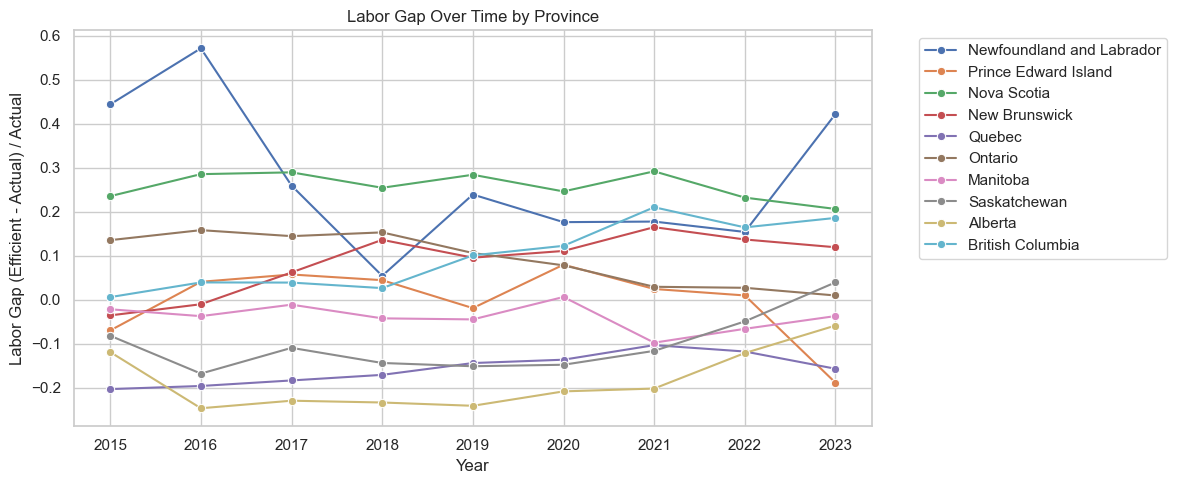

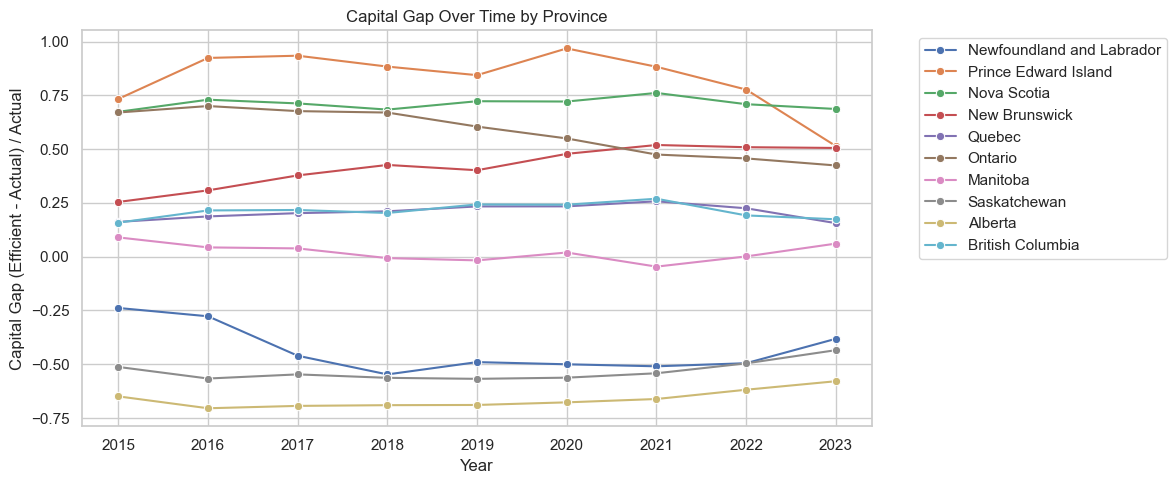

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Provinces_with_productivities.csv")

# Set plot style
sns.set(style="whitegrid")

# Plot: Labor Gap over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="Year", y="labor_gap", hue="GEO", marker="o")
plt.title("Labor Gap Over Time by Province")
plt.ylabel("Labor Gap (Efficient - Actual) / Actual")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot: Capital Gap over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="Year", y="capital_gap", hue="GEO", marker="o")
plt.title("Capital Gap Over Time by Province")
plt.ylabel("Capital Gap (Efficient - Actual) / Actual")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [138]:
# Efficient GDP clearly computed:
df_prov['Y_eff'] = (df_prov['s_raw'] ** (1 - gamma)) * ((df_prov['L_eff'] ** (1 - df_prov['alpha'])) * (df_prov['K_eff'] ** df_prov['alpha'])) ** gamma

# Now sum clearly to get efficient GDP for Canada each year:
efficient_gdp = df_prov.groupby('Year')['Y_eff'].sum().reset_index(name='Efficient_GDP')

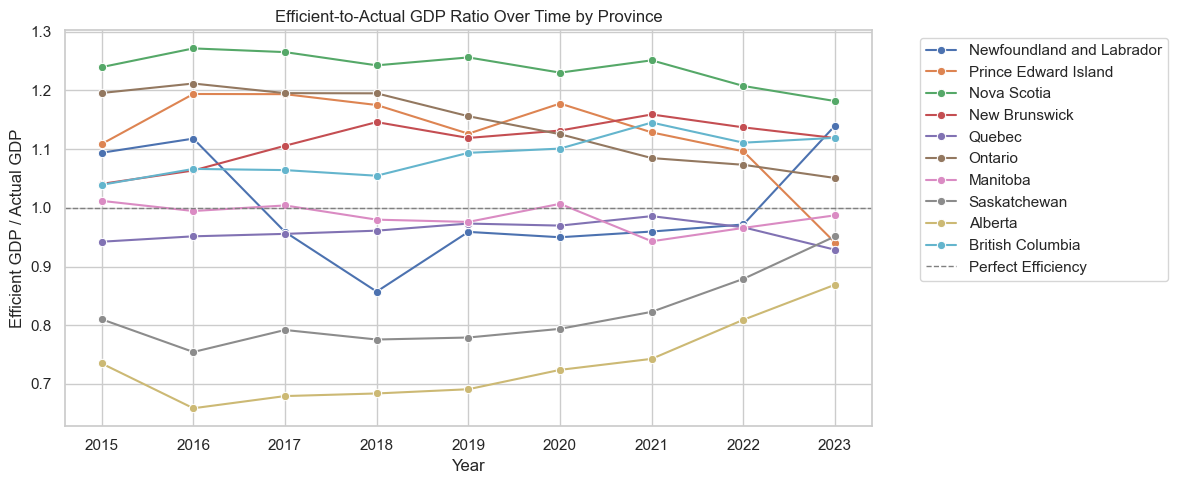

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Provinces_with_productivities.csv")

# Step 1: Calculate the ratio
df["gdp_ratio"] = df["Y_eff"] / df["Y"]

# Step 2: Plot the ratio over time by province
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="Year", y="gdp_ratio", hue="GEO", marker="o")
plt.title("Efficient-to-Actual GDP Ratio Over Time by Province")
plt.ylabel("Efficient GDP / Actual GDP")
plt.xlabel("Year")
plt.axhline(1, color='gray', linestyle='--', linewidth=1, label="Perfect Efficiency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd

# Load dataset with provincial GDPs
df = pd.read_csv("Provinces_with_productivities.csv")

# Load dataset that includes national-level Canada GDP
df_full = pd.read_csv("Merged_K_Y_L_WAGE.csv")  # This includes Canada

# Step 1: Aggregate efficient GDP across provinces (exclude Canada)
prov_gdp_eff = df.groupby("Year")["Y_eff"].sum().reset_index(name="Y_eff_total")

# Step 2: Get Canada's actual GDP
canada_gdp = df_full[df_full["GEO"] == "Canada"][["Year", "Y"]].rename(columns={"Y": "Y_canada"})

# Step 3: Merge the two
comparison = prov_gdp_eff.merge(canada_gdp, on="Year", how="inner")

# Step 4: Compute percentage gain
comparison["percent_gain"] = ((comparison["Y_eff_total"] - comparison["Y_canada"]) / comparison["Y_canada"]) * 100

# Step 5: Output
print("✅ Efficient GDP vs Actual Canada GDP:")
print(comparison)

# Optional: save to file
comparison.to_csv("GDP_Efficiency_Gain_Comparison.csv", index=False)

✅ Efficient GDP vs Actual Canada GDP:
   Year   Y_eff_total  Y_canada  percent_gain
0  2015  2.136206e+06   2091469      2.139046
1  2016  2.156054e+06   2101103      2.615347
2  2017  2.221167e+06   2170094      2.353492
3  2018  2.276981e+06   2228262      2.186419
4  2019  2.300962e+06   2257230      1.937409
5  2020  2.199044e+06   2164051      1.617034
6  2021  2.334594e+06   2302441      1.396461
7  2022  2.403631e+06   2379170      1.028150
8  2023  2.422920e+06   2405571      0.721213


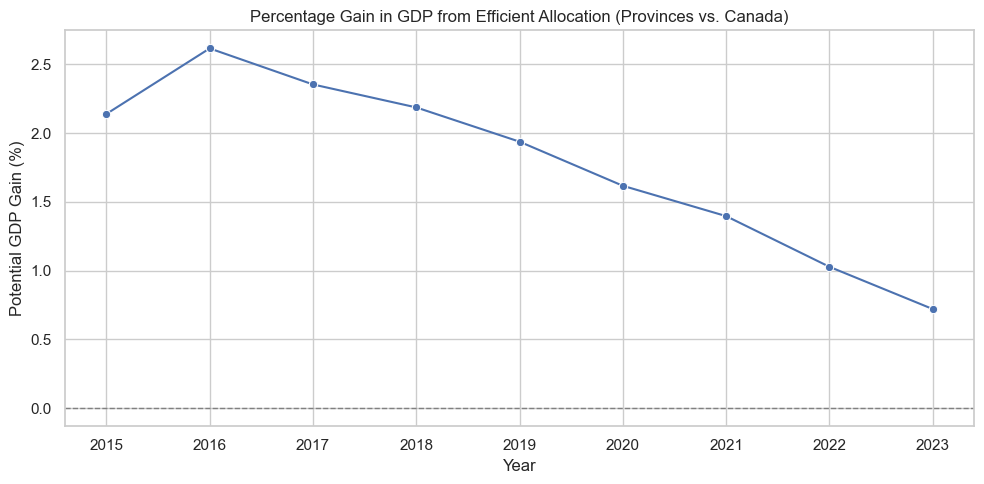

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set a clean style
sns.set(style="whitegrid")

# Plot percentage GDP gain over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=comparison, x="Year", y="percent_gain", marker="o")

# Add titles and labels
plt.title("Percentage Gain in GDP from Efficient Allocation")
plt.xlabel("Year")
plt.ylabel("Potential GDP Gain (%)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Improve layout
plt.tight_layout()
plt.show()

Standard deviation of log TFPR: 0.052407481138068174
TFP Gain from reallocation: 0.61%


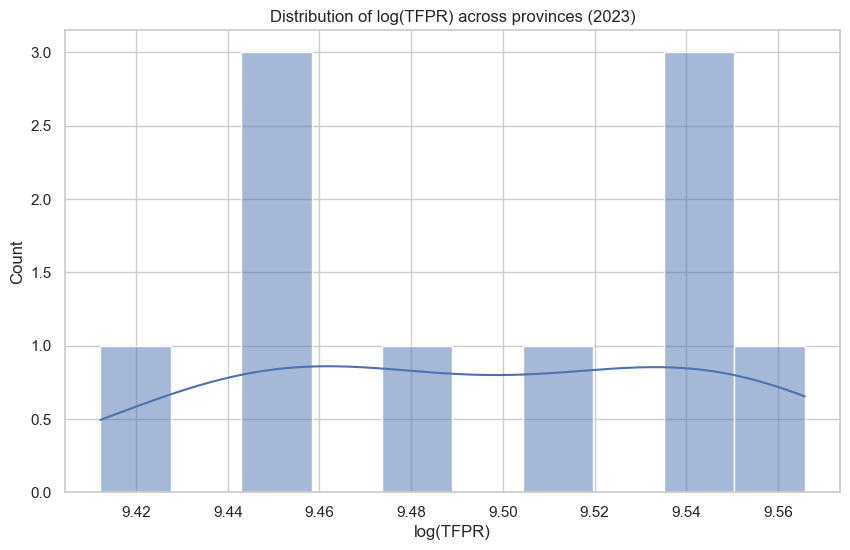

In [33]:
import numpy as np

# Make sure TFPR > 0 before taking log
df_2023 = df_2023[df_2023['TFPR'] > 0].copy()

# Take log TFPR
df_2023['log_TFPR'] = np.log(df_2023['TFPR'])

# Compute standard deviation of log TFPR
std_log_tfpr = df_2023['log_TFPR'].std()
print("Standard deviation of log TFPR:", std_log_tfpr)

alpha = 0.3259

# TFP gain from reducing dispersion to zero
tfp_gain = np.exp((std_log_tfpr ** 2) / (1 - alpha) ** 2)
tfp_gain_percent = (tfp_gain - 1) * 100
print(f"TFP Gain from reallocation: {tfp_gain_percent:.2f}%")


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_2023['log_TFPR'], kde=True, bins=10)
plt.title("Distribution of log(TFPR) across provinces (2023)")
plt.xlabel("log(TFPR)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


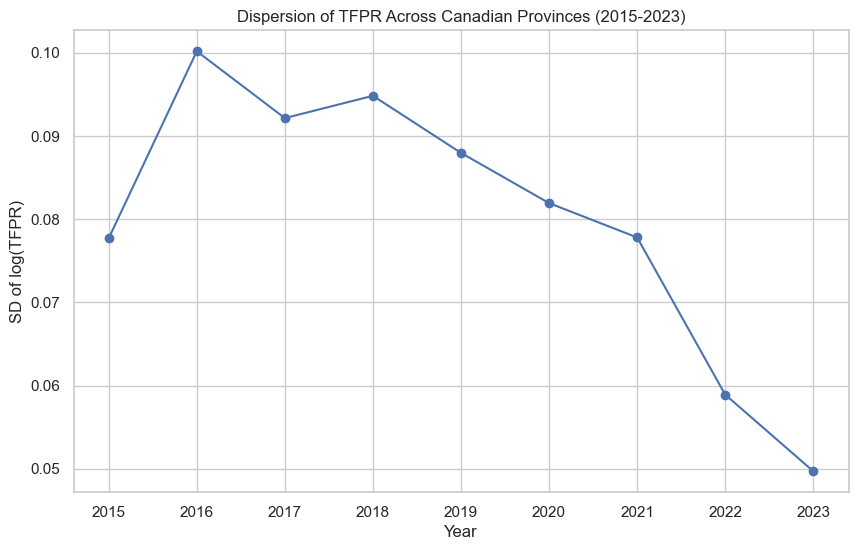

In [34]:
dispersion_df = df.groupby('Year')['TFPR'].apply(lambda x: np.std(np.log(x))).reset_index()
dispersion_df.columns = ['Year', 'TFPR_dispersion']
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(dispersion_df['Year'], dispersion_df['TFPR_dispersion'], marker='o')
plt.xlabel('Year')
plt.ylabel('SD of log(TFPR)')
plt.title('Dispersion of TFPR Across Canadian Provinces (2015-2023)')
plt.grid(True)
plt.show()
import statsmodels.formula.api as smf

In [36]:
import pandas as pd

# Load the dataset with s_i
df = pd.read_csv("Provinces_with_productivities.csv")

# Set gamma and compute 1 - gamma
gamma = 2 / 3
one_minus_gamma = 1 - gamma

# Compute TFP
df["TFP"] = df["s_i"] ** one_minus_gamma

# Save the updated dataset
df.to_csv("Provinces_with_TFP.csv", index=False)

# Preview result
print("✅ TFP computed for each province and year.")
print(df[["Year", "GEO", "s_i", "TFP"]].head(10))

✅ TFP computed for each province and year.
   Year                        GEO           s_i           TFP
0  2015  Newfoundland and Labrador  1.068118e+11   4744.674149
1  2016  Newfoundland and Labrador  1.054196e+11   4723.969272
2  2017  Newfoundland and Labrador  1.373674e+11   5159.741185
3  2018  Newfoundland and Labrador  1.549715e+11   5371.356266
4  2019  Newfoundland and Labrador  3.075870e+11   6750.293678
5  2020  Newfoundland and Labrador  5.896349e+11   8385.475954
6  2021  Newfoundland and Labrador  1.071763e+12  10233.706549
7  2022  Newfoundland and Labrador  2.373338e+12  13338.894640
8  2023  Newfoundland and Labrador  6.968823e+12  19100.869778
9  2015       Prince Edward Island  2.113657e+10   2764.892193


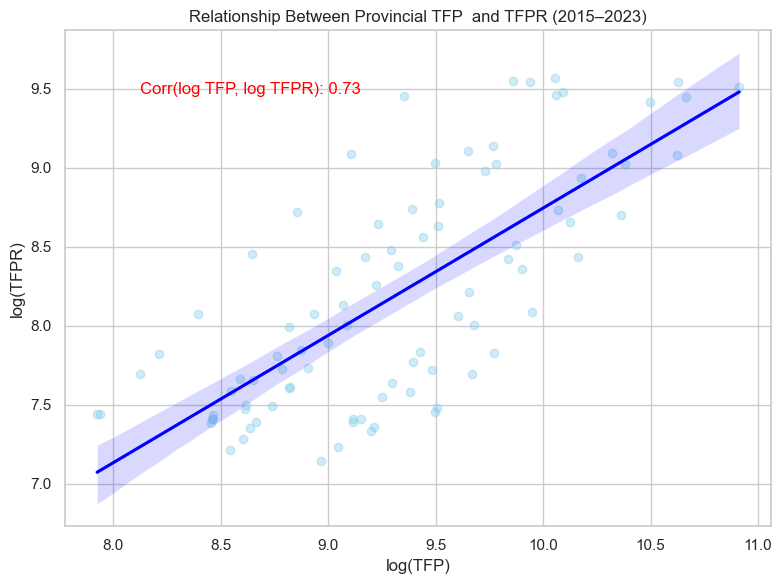

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset that includes TFP and TFPR
df = pd.read_csv("Provinces_with_TFP.csv")

# Compute logs
df["log_TFP"] = np.log(df["TFP"])
df["log_TFPR"] = np.log(df["TFPR"])

# Compute correlation
corr = df["log_TFP"].corr(df["log_TFPR"])

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x="log_TFP", y="log_TFPR", scatter_kws={'alpha':0.4, 'color':'skyblue'}, line_kws={'color':'blue'})
plt.title("Relationship Between Provincial TFP  and TFPR (2015–2023)")
plt.xlabel("log(TFP)")
plt.ylabel("log(TFPR)")

# Add correlation in red text
plt.text(df["log_TFP"].min() + 0.2, df["log_TFPR"].max() - 0.1, 
         f"Corr(log TFP, log TFPR): {corr:.2f}", 
         fontsize=12, color='red')

plt.tight_layout()
plt.show()

In [136]:
# Calculate variance of log TFPR by year
tfpr_variance_df = df_prov.groupby('Year').apply(
    lambda x: np.var(np.log(x['TFPR']), ddof=1)
).reset_index(name='var_log_TFPR')

# Calculate potential TFP gains explicitly each year
tfpr_variance_df['TFP_gain_pct'] = 100 * (
    np.exp(0.5 * tfpr_variance_df['var_log_TFPR'] * gamma / (1 - gamma)) - 1
)

print(tfpr_variance_df)

   Year  var_log_TFPR  TFP_gain_pct
0  2015        0.0160        1.6134
1  2016        0.0167        1.6865
2  2017        0.0224        2.2667
3  2018        0.0323        3.2814
4  2019        0.0266        2.6912
5  2020        0.0255        2.5819
6  2021        0.0260        2.6381
7  2022        0.0226        2.2863
8  2023        0.0252        2.5483


C:\Users\logc0\AppData\Local\Temp\ipykernel_70556\2546172907.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tfpr_variance_df = df_prov.groupby('Year').apply(


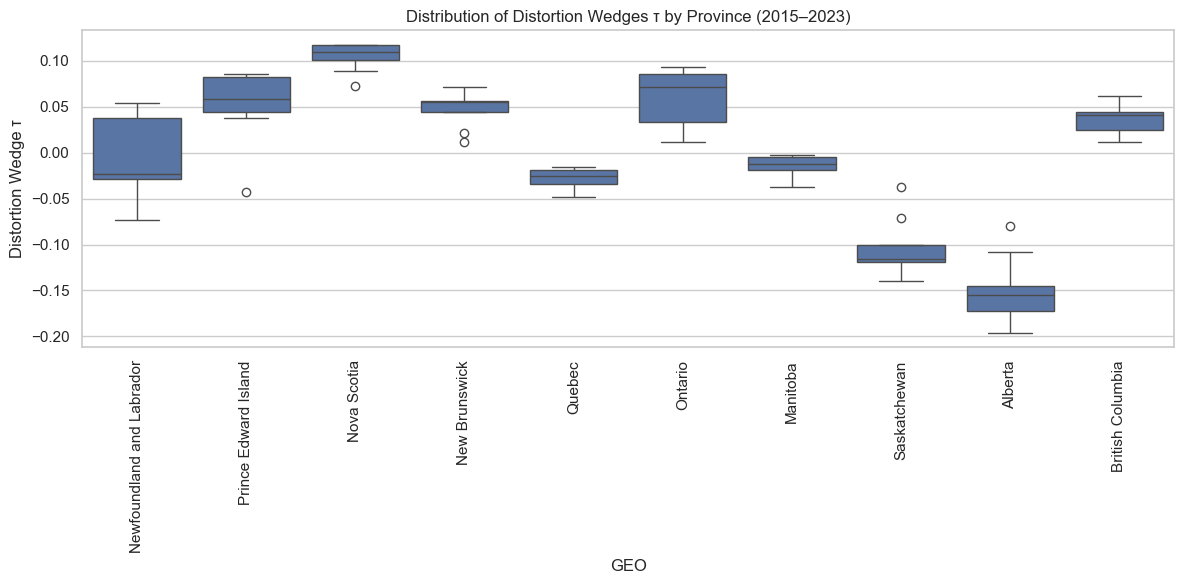

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data with TFPR
df = pd.read_csv("Provinces_with_TFP.csv")

# Step 1: Compute average TFPR by year
df["TFPR_bar"] = df.groupby("Year")["TFPR"].transform("mean")

# Step 2: Compute τ_i (distortion wedge)
df["tau"] = df["TFPR"] / df["TFPR_bar"] - 1

# Step 3: Plot boxplot of τ_i by province
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="GEO", y="tau")
plt.xticks(rotation=90)
plt.title("Distribution of Distortion Wedges τ by Province (2015–2023)")
plt.ylabel("Distortion Wedge τ")
plt.xlabel("GEO")
plt.tight_layout()
plt.show()